# Crowd Counting P2PNet Narrative Report

Menelusuri tantangan estimasi kerumunan melalui pendekatan point-based detection yang diadopsi P2PNet.

> **Tim**: Kibahino  
> **Anggota**: Rhendy Japelhendal S. S., Gaung Taqwa Indraswara, Muhammad Irza Dzulhika  
> **Institusi**: Universitas Brawijaya

## Daftar Isi

- [Pendahuluan](#pendahuluan)
  - [Latar Cerita](#latar-cerita)
  - [Referensi Inspirasi](#referensi-inspirasi)
- [Dataset & Eksplorasi](#dataset--eksplorasi)
  - [Setup Lingkungan](#setup-lingkungan)
  - [Struktur Dataset Kustom](#struktur-dataset-kustom)
  - [Contoh Anotasi Mentah](#contoh-anotasi-mentah)
  - [Konversi ke Format P2PNet](#konversi-ke-format-p2pnet)
  - [Eksplorasi Statistik](#eksplorasi-statistik)
  - [Visual Diagnostics](#visual-diagnostics)
  - [Ground Truth Spot Check](#ground-truth-spot-check)
  - [Contoh Dataset yang Sudah Terkonversi](#contoh-dataset-yang-sudah-terkonversi)
- [Arsitektur & Pelatihan Model](#arsitektur--pelatihan-model)
  - [Konfigurasi Eksperimen](#konfigurasi-eksperimen)
  - [Snapshot Argumen](#snapshot-argumen)
  - [Rangkaian Training](#rangkaian-training)
  - [Menyiapkan Dataset Latih & Validasi](#menyiapkan-dataset-latih--validasi)
  - [Utilitas Pelatihan — Logging & Evaluasi Intermediate](#utilitas-pelatihan--logging--evaluasi-intermediate)
  - [Menyusun Arsitektur & Strategi Optimisasi](#menyusun-arsitektur--strategi-optimisasi)
  - [Komponen Matcher & Loss P2PNet](#komponen-matcher--loss-p2pnet)
  - [Menyatukan Komponen P2PNet](#menyatukan-komponen-p2pnet)
  - [Pipeline Pelatihan — Fungsi `main`](#pipeline-pelatihan--fungsi-main)
- [Evaluasi & Visualisasi](#evaluasi--visualisasi)
  - [Inferensi Uji](#inferensi-uji)
  - [Kasus Ekstrem](#kasus-ekstrem)
  - [Overlay Prediksi vs Ground Truth](#overlay-prediksi-vs-ground-truth)
- [Insight & Rekomendasi](#insight--rekomendasi)
  - [Catatan Model Alternatif](#catatan-model-alternatif)

## Pendahuluan <a id="pendahuluan"></a>

Ketika sebuah festival kota memuncak, petugas keamanan kerap bertanya: *berapa banyak kepala yang sedang kami kawal sekarang?* Jawaban cepat dan akurat menjadi krusial, namun lapangan penuh occlusion dan skala yang berubah-ubah. Notebook ini merangkum perjalanan tim kami menelisik persoalan tersebut—mulai dari memahami sumber data, merancang pendekatan point-based, hingga memeriksa hasil model secara kritis.

### Latar Cerita <a id="latar-cerita"></a>

Cerita kami dimulai dari kumpulan citra kerumunan yang padat, lengkap dengan anotasi koordinat kepala. Alih-alih sekadar menghitung piksel terang pada density map, kami ingin memastikan setiap manusia dihitung sebagai individu. Pendekatan ini menuntut pipeline yang mampu:

- Menjaga kualitas anotasi titik ketika dikonversi ke format baru.
- Menganalisis distribusi kepadatan agar model tidak terjebak bias.
- Menghasilkan prediksi koordinat yang bisa dipertanggungjawabkan secara visual.

### Referensi Inspirasi <a id="referensi-inspirasi"></a>

Kami terinspirasi oleh karya **“Rethinking Counting and Localization in Crowds: A Purely Point-Based Framework”** karya Qingyu Song dkk. dari Tencent Youtu Lab. Paper tersebut menggarisbawahi keunggulan pendekatan point-based dalam menyatukan counting dan localization tanpa bergantung pada density map. Notebook ini mencoba menerjemahkan gagasan tersebut ke dalam konteks dataset yang kami miliki, sambil menambahkan analisis dan visualisasi yang relevan dengan kebutuhan lapangan kami.

## Dataset & Eksplorasi <a id="dataset--eksplorasi"></a>

Kami menyiapkan serangkaian langkah untuk memahami data sebelum menyentuh model. Ceritanya berawal dari lingkungan komputasi yang rapi, berlanjut ke investigasi struktur dataset, hingga mengintip karakter kepadatan kerumunan melalui visual.

In [29]:
# Setup & Imports
import os
import sys
import time
import datetime
import random
import math
import glob
import shutil
import json
import csv
import pickle
import subprocess
import warnings
from pathlib import Path
from collections import defaultdict, deque
from typing import Optional, List
from typing import Iterable
import argparse

import numpy as np
import pandas as pd
import scipy.io as io
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch import Tensor
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms as standard_transforms
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display

warnings.filterwarnings('ignore')

# Device default (can be overridden later by args)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


> Catatan: eksekusi sel ini menampilkan perangkat komputasi yang tersedia dan menonaktifkan peringatan agar alur eksperimen tetap bersih.

### Setup Lingkungan <a id="setup-lingkungan"></a>

Lingkungan komputasi yang konsisten menjadi fondasi cerita ini. Kami memuat pustaka utama—mulai dari PyTorch untuk pemodelan hingga Pandas dan Matplotlib untuk analitik—serta mendeteksi perangkat komputasi yang akan menggerakkan eksperimen.

## Problem Motivation & Dataset
Crowd management demands rapid, reliable head-counting even in dense gatherings. Our dataset originates from urban surveillance captures converted into the P2PNet-friendly SHHA format. Each sample couples an RGB image with precise head coordinates, enabling both detection and counting tasks. Before touching the model, we anchor ourselves in the data semantics, ensuring the downstream choices stay aligned with real-world requirements.

In [30]:
# Data Loading
class CrowdDataset(Dataset):
    def __init__(self, data_root, transform=None, train=False, patch=False, flip=False):
        self.root_path = data_root
        # daftar file list
        self.train_lists = "train.list"
        self.eval_list = "test.list"

        if train:
            self.img_list_file = self.train_lists.split(',')
        else:
            self.img_list_file = self.eval_list.split(',')

        self.img_map = {}
        self.img_list = []

        # baca daftar gambar dan label dari list file
        for _, train_list in enumerate(self.img_list_file):
            train_list = train_list.strip()
            with open(os.path.join(self.root_path, train_list)) as fin:
                for line in fin:
                    if len(line) < 2:
                        continue
                    line = line.strip().split()
                    self.img_map[os.path.join(self.root_path, line[0].strip())] = \
                                    os.path.join(self.root_path, line[1].strip())

        self.img_list = sorted(list(self.img_map.keys()))
        self.nSamples = len(self.img_list)

        self.transform = transform
        self.train = train
        self.patch = patch
        self.flip = flip

    def __len__(self):
        return self.nSamples

    def __getitem__(self, index):
        assert index <= len(self), 'index range error'

        img_path = self.img_list[index]
        gt_path = self.img_map[img_path]

        img, point = load_data((img_path, gt_path), self.train)

        if self.transform is not None:
            img = self.transform(img)

        if self.train:
            # data augmentation → random scale
            scale_range = [0.7, 1.3]
            min_size = min(img.shape[1:])
            scale = random.uniform(*scale_range)
            if scale * min_size > 128:
                img = torch.nn.functional.interpolate(img.unsqueeze(0), scale_factor=scale, mode='bilinear').squeeze(0)
                point *= scale

        # random crop augmentation
        if self.train and self.patch:
            img, point = random_crop(img, point)
            for i, _ in enumerate(point):
                point[i] = torch.Tensor(point[i])

        # random flipping
        if random.random() > 0.5 and self.train and self.flip:
            img = torch.Tensor(img[:, :, :, ::-1].copy())
            for i, _ in enumerate(point):
                point[i][:, 0] = 128 - point[i][:, 0]

        if not self.train:
            point = [point]

        img = torch.Tensor(img)

        # pack target info
        target = [{} for _ in range(len(point))]
        for i, _ in enumerate(point):
            target[i]['point'] = torch.Tensor(point[i])
            image_id = int(os.path.basename(img_path).split('.')[0].split('_')[-1])
            target[i]['image_id'] = torch.tensor([image_id]).long()
            target[i]['labels'] = torch.ones([point[i].shape[0]]).long()

        return img, target

def load_data(img_gt_path, train):
    img_path, gt_path = img_gt_path
    img = cv2.imread(img_path)
    img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    points = []
    with open(gt_path) as f_label:
        for line in f_label:
            x, y = line.strip().split(' ')
            points.append([float(x), float(y)])
    return img, np.array(points)


def random_crop(img, den, num_patch=4):
    half_h, half_w = 128, 128
    result_img = np.zeros([num_patch, img.shape[0], half_h, half_w])
    result_den = []
    for i in range(num_patch):
        start_h = random.randint(0, img.size(1) - half_h)
        start_w = random.randint(0, img.size(2) - half_w)
        end_h = start_h + half_h
        end_w = start_w + half_w
        result_img[i] = img[:, start_h:end_h, start_w:end_w]
        idx = (den[:, 0] >= start_w) & (den[:, 0] <= end_w) & \
              (den[:, 1] >= start_h) & (den[:, 1] <= end_h)
        record_den = den[idx]
        record_den[:, 0] -= start_w
        record_den[:, 1] -= start_h
        result_den.append(record_den)
    return result_img, result_den

> Setelah tahap konversi selesai, struktur dataset siap digunakan tanpa penyesuaian tambahan.

### Contoh Anotasi Mentah <a id="contoh-anotasi-mentah"></a>

Untuk memahami struktur data sumber, kami mengintip salah satu berkas JSON sebelum dikonversi. Potongan ini membantu memastikan koordinat disimpan dalam format yang konsisten di seluruh adegan.

In [31]:
# Data Peek — Raw JSON Sample
from pathlib import Path
import json
import pandas as pd

json_preview = None
json_source = None
candidate_dirs = []
if 'base_dir' in globals():
    candidate_dirs.append(Path(base_dir))
candidate_dirs.append(Path('/kaggle/input/final-hology-8-0-2025-data-mining'))
if 'args' in globals() and hasattr(args, 'data_root'):
    candidate_dirs.append(Path(args.data_root))
else:
    candidate_dirs.append(Path('/kaggle/working/crowdmine_p2pnet_format'))

for root_dir in candidate_dirs:
    if root_dir.exists():
        json_files = sorted(root_dir.rglob('*.json'))
        if json_files:
            json_source = json_files[0]
            with open(json_source, 'r') as f:
                json_data = json.load(f)
            points = json_data.get('points', [])
            if points and isinstance(points[0], dict):
                points = [[pt.get('x'), pt.get('y')] for pt in points]
            json_preview = pd.DataFrame(points, columns=['x', 'y']).head(10)
            break

if json_preview is not None:
    display(pd.DataFrame({'source_json': [str(json_source)], 'total_points_in_preview': [len(json_preview)]}))
    display(json_preview)
else:
    print('Tidak menemukan berkas JSON contoh pada lokasi yang dicoba.')

,source_json,total_points_in_preview
0,/kaggle/input/final-hology-8-0-2025-data-minin...,10


,x,y
0,268.175642,197.865783
1,232.119304,96.908036
2,44.626346,21.189727
3,19.386910,84.889257
4,254.954985,64.457332
5,289.809445,345.696769
6,358.316487,432.231980
7,454.466722,556.025407
8,460.476112,400.983154
9,541.001933,316.851698


> Cuplikan tabel ini memverifikasi bahwa koordinat mentah tersimpan rapi dan siap dikonversi ke format lain tanpa kehilangan presisi.

### Struktur Dataset Kustom <a id="struktur-dataset-kustom"></a>

Kami membangun `CrowdDataset` untuk membaca pasangan citra–anotasi dari daftar berkas. Setiap anotasi berupa koordinat kepala yang harus dijaga presisinya. Di sinilah kami menyiapkan augmentation berupa skala acak, patching, dan flipping untuk menambah keragaman tanpa merusak makna titik.

In [32]:
# Data Loading Utilities
class DeNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


def loading_data(data_root):
    transform = standard_transforms.Compose([
        standard_transforms.ToTensor(),
        standard_transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225]),
    ])
    train_set = CrowdDataset(data_root, train=True, transform=transform, patch=True, flip=True)
    val_set = CrowdDataset(data_root, train=False, transform=transform)
    return train_set, val_set

> Catatan: fungsi pemuatan ini tidak menghasilkan output, namun menjadi fondasi agar citra dapat dipulihkan ke ruang warna aslinya saat divisualisasikan.

### Utilitas Pra-pemrosesan

Fungsi seperti `DeNormalize` kami siapkan untuk mengembalikan citra ke warna aslinya ketika nanti divisualisasikan. Detail kecil ini menjaga cerita visual tetap akurat meski tensor telah melalui berbagai normalisasi.

In [34]:
# Dataset Factory
def build_dataset(args):
    if args.dataset_file in ['SHHA', 'CrowdMine']:
        return loading_data
    return None

> Catatan: tahap ini bersifat persiapan—fungsinya baru terasa ketika proses training dan inference membutuhkan dataset yang konsisten.

### Builder Split Train–Val

Fungsi pembantu ini menyatukan definisi dataset menjadi pasangan train dan val. Dengan cara ini kami bisa memanggilnya kapan pun tanpa memikirkan ulang struktur path.

In [36]:
# Dataset Instantiation for Exploratory Analysis
DEFAULT_DATA_ROOT = Path('/kaggle/working/crowdmine_p2pnet_format')
if not DEFAULT_DATA_ROOT.exists():
    print('Default data root not found. Please update DEFAULT_DATA_ROOT before running the EDA cells.')
    train_set, val_set = [], []
else:
    train_set, val_set = loading_data(str(DEFAULT_DATA_ROOT))
    print(f"Training samples available: {len(train_set)}")
    print(f"Validation samples available: {len(val_set)}")

Training samples available: 1100
Validation samples available: 400


In [37]:
# Exploratory Data Analysis — Dataset Profile
EDA_SAMPLE_LIMIT = min(len(train_set), 500)
eda_records = []

for sample_idx in range(EDA_SAMPLE_LIMIT):
    imgs, targets = train_set[sample_idx]
    if isinstance(targets, dict):
        targets = [targets]
    if isinstance(imgs, torch.Tensor):
        patch_imgs = imgs.unsqueeze(0) if imgs.ndim == 3 else imgs
    else:
        patch_imgs = torch.tensor(imgs)
        patch_imgs = patch_imgs.unsqueeze(0) if patch_imgs.ndim == 3 else patch_imgs

    for patch_idx, target in enumerate(targets):
        patch_img = patch_imgs[patch_idx] if patch_idx < len(patch_imgs) else patch_imgs[0]
        points = target['point']
        if isinstance(points, torch.Tensor):
            points_np = points.cpu().numpy()
        else:
            points_np = np.asarray(points)
        num_people = int(points_np.shape[0])
        width = int(patch_img.shape[-1])
        height = int(patch_img.shape[-2])
        eda_records.append({
            "image_index": sample_idx,
            "patch_index": patch_idx,
            "people_count": num_people,
            "patch_width": width,
            "patch_height": height,
            "density_per_1kpx": float(num_people / ((width * height) / 1000.0)) if width * height > 0 else np.nan
        })

eda_stats_df = pd.DataFrame(eda_records)

print(f"Samples analysed: {EDA_SAMPLE_LIMIT} / {len(train_set)}")
if not eda_stats_df.empty:
    display(eda_stats_df.describe(include='all').transpose().round(2))
    top_dense = eda_stats_df.sort_values('density_per_1kpx', ascending=False).head(5)[['image_index', 'patch_index', 'people_count', 'density_per_1kpx']]
    print("\nTop 5 densest patches (people per 1k pixels):")
    display(top_dense)
else:
    print("Dataset statistics could not be computed — dataset may be empty.")

Samples analysed: 500 / 1100


,count,mean,std,min,25%,50%,75%,max
image_index,2000.0,249.50,144.37,0.0,124.75,249.50,374.25,499.00
patch_index,2000.0,1.50,1.12,0.0,0.75,1.50,2.25,3.00
people_count,2000.0,1.20,1.91,0.0,0.00,1.00,2.00,21.00
patch_width,2000.0,128.00,0.00,128.0,128.00,128.00,128.00,128.00
patch_height,2000.0,128.00,0.00,128.0,128.00,128.00,128.00,128.00
density_per_1kpx,2000.0,0.07,0.12,0.0,0.00,0.06,0.12,1.28



Top 5 densest patches (people per 1k pixels):


,image_index,patch_index,people_count,density_per_1kpx
1059,264,3,21,1.281738
233,58,1,19,1.159668
1058,264,2,16,0.976562
474,118,2,16,0.976562
673,168,1,15,0.915527


> Statistik deskriptif ini membantu menyoroti patch dengan kepadatan tertinggi, menjadi referensi penting saat memvalidasi performa model.

### Eksplorasi Statistik <a id="eksplorasi-statistik"></a>

Sebelum menilai model, kami memotret statistik ringkas dari ratusan patch latih. Jumlah kepala, ukuran patch, hingga kepadatan per 1.000 piksel memberi narasi tentang betapa heterogennya kerumunan yang harus dikenali model.

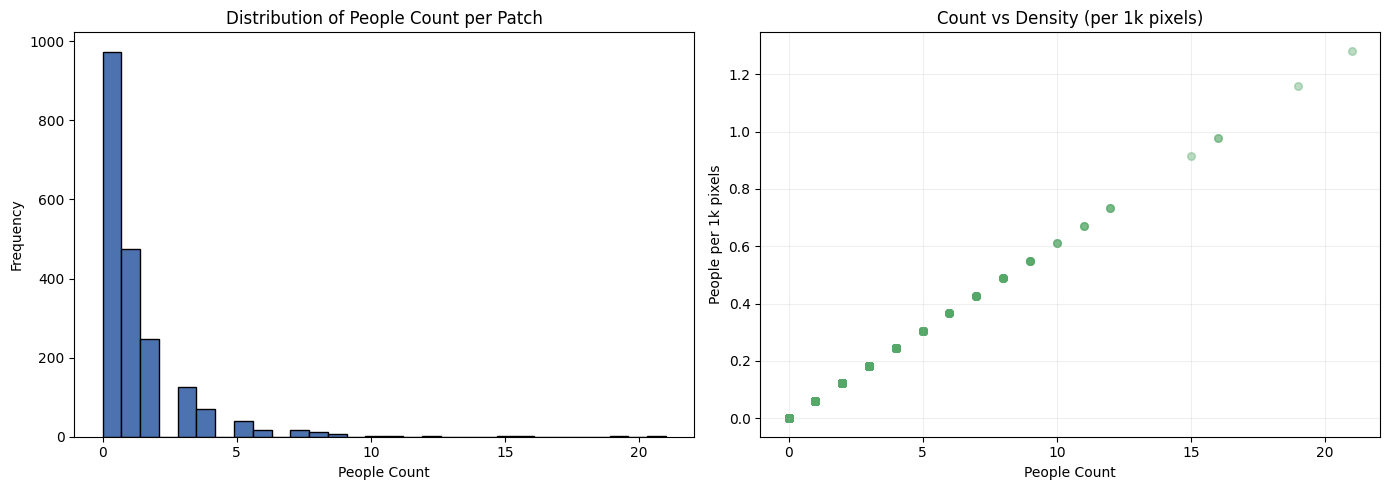

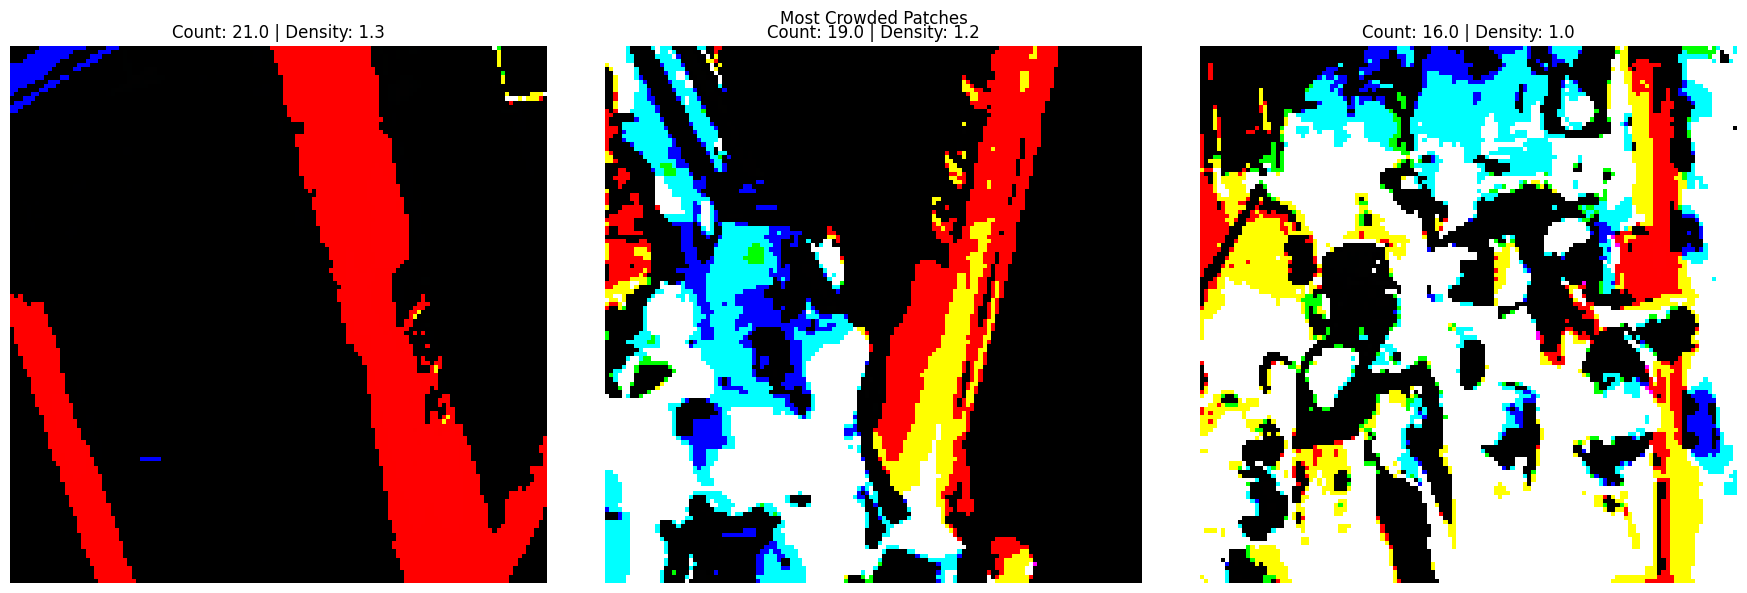

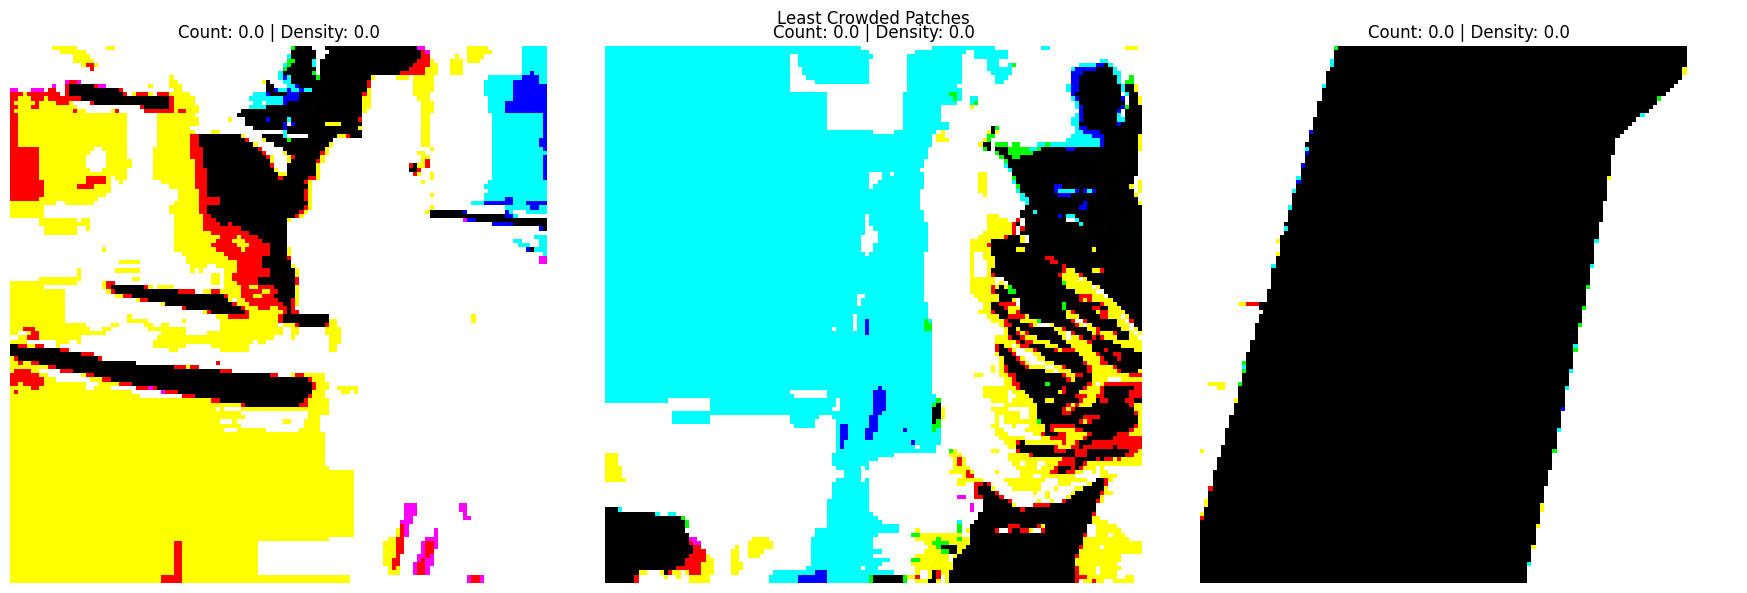

In [38]:
# Exploratory Data Analysis — Visual Diagnostics
if eda_stats_df.empty:
    print("Skipping visual diagnostics — no EDA statistics available.")
else:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    eda_stats_df['people_count'].plot(kind='hist', bins=30, ax=axes[0], color='#4C72B0', edgecolor='black')
    axes[0].set_title('Distribution of People Count per Patch')
    axes[0].set_xlabel('People Count')
    axes[0].set_ylabel('Frequency')

    axes[1].scatter(eda_stats_df['people_count'], eda_stats_df['density_per_1kpx'], alpha=0.4, s=30, color='#55A868')
    axes[1].set_title('Count vs Density (per 1k pixels)')
    axes[1].set_xlabel('People Count')
    axes[1].set_ylabel('People per 1k pixels')
    axes[1].grid(alpha=0.2)

    plt.tight_layout()
    plt.show()

    def show_sample_patch(row):
        sample = train_set[int(row['image_index'])]
        imgs, targets = sample
        if isinstance(targets, dict):
            targets = [targets]
        if isinstance(imgs, torch.Tensor):
            patch_imgs = imgs.unsqueeze(0) if imgs.ndim == 3 else imgs
        else:
            patch_imgs = torch.tensor(imgs)
            patch_imgs = patch_imgs.unsqueeze(0) if patch_imgs.ndim == 3 else patch_imgs
        patch_idx = int(row['patch_index'])
        patch_img = patch_imgs[patch_idx] if patch_idx < len(patch_imgs) else patch_imgs[0]
        patch_np = patch_img.permute(1, 2, 0).cpu().numpy()
        patch_np = np.clip((patch_np * 255.0), 0, 255).astype(np.uint8) if patch_np.max() <= 1.0 else patch_np.astype(np.uint8)
        plt.imshow(patch_np)
        plt.axis('off')
        plt.title(f"Count: {row['people_count']} | Density: {row['density_per_1kpx']:.1f}")

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for ax, (_, row) in zip(axes, eda_stats_df.sort_values('people_count', ascending=False).head(3).iterrows()):
        plt.sca(ax)
        show_sample_patch(row)
    plt.suptitle('Most Crowded Patches')
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    for ax, (_, row) in zip(axes, eda_stats_df.sort_values('people_count').head(3).iterrows()):
        plt.sca(ax)
        show_sample_patch(row)
    plt.suptitle('Least Crowded Patches')
    plt.tight_layout()
    plt.show()

> Visualisasi distribusi membantu mengukur variasi kepadatan—kombinasi histogram dan scatter plot memberi konteks sebelum kami melangkah ke training.

### Visual Diagnostics <a id="visual-diagnostics"></a>

Histogram jumlah kepala dan scatter antara jumlah vs kepadatan memberi intuisi apakah dataset condong ke kerumunan sepi atau padat. Kami juga menampilkan patch paling ramai dan paling lengang sebagai potret ekstrem.

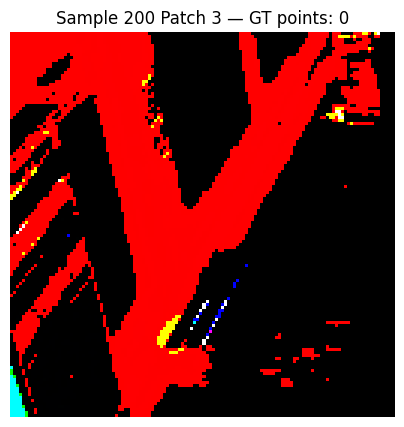

In [39]:
# Exploratory Data Analysis — Ground Truth Points
if len(train_set) == 0:
    print("Train set empty; cannot visualize ground truth points.")
else:
    sample_index = random.randint(0, len(train_set) - 1)
    sample_imgs, sample_targets = train_set[sample_index]
    if isinstance(sample_targets, dict):
        sample_targets = [sample_targets]
    if isinstance(sample_imgs, torch.Tensor):
        sample_patches = sample_imgs.unsqueeze(0) if sample_imgs.ndim == 3 else sample_imgs
    else:
        sample_patches = torch.tensor(sample_imgs)
        sample_patches = sample_patches.unsqueeze(0) if sample_patches.ndim == 3 else sample_patches

    patch_index = random.randint(0, len(sample_targets) - 1)
    patch_img = sample_patches[patch_index] if patch_index < len(sample_patches) else sample_patches[0]
    patch_np = patch_img.detach().cpu()
    if patch_np.ndim == 3:
        patch_np = patch_np.permute(1, 2, 0)
    patch_np = patch_np.numpy()
    if patch_np.max() <= 1.0:
        patch_np = np.clip(patch_np * 255.0, 0, 255).astype(np.uint8)
    else:
        patch_np = patch_np.astype(np.uint8)

    points = sample_targets[patch_index]['point']
    if isinstance(points, torch.Tensor):
        points_np = points.detach().cpu().numpy()
    else:
        points_np = np.asarray(points)

    plt.figure(figsize=(5, 5))
    plt.imshow(patch_np)
    if points_np.size > 0:
        plt.scatter(points_np[:, 0], points_np[:, 1], s=25, edgecolors='cyan', facecolors='none', linewidths=1.5)
    plt.title(f"Sample {sample_index} Patch {patch_index} — GT points: {points_np.shape[0]}")
    plt.axis('off')
    plt.show()

> Titik anotasi berwarna membantu kami menilai apakah proses konversi mempertahankan posisi kepala secara akurat.

### Ground Truth Spot Check

Kami mengambil patch secara acak dan menempelkan titik anotasi untuk memastikan tidak ada distorsi selama konversi. Ini semacam sesi inspeksi kualitas sebelum melibatkan model.

In [40]:
# Preprocessing
base_dir = "/kaggle/input/final-hology-8-0-2025-data-mining"

# Output dataset in SHHA layout
output_dir = "/kaggle/working/crowdmine_p2pnet_format"
os.makedirs(output_dir, exist_ok=True)

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

for split in ["train", "test"]:
    img_in_dir = os.path.join(base_dir, split, "images")
    label_in_dir = os.path.join(base_dir, split, "labels")
    if not os.path.exists(img_in_dir):
        continue

    scene_dir = os.path.join(output_dir, split, "scene01")
    ensure_dir(scene_dir)

    list_path = os.path.join(output_dir, f"{split}.list")

    with open(list_path, "w") as list_file:
        for img_name in tqdm(sorted(os.listdir(img_in_dir)), desc=f"Converting {split}"):
            if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            img_src = os.path.join(img_in_dir, img_name)
            json_path = os.path.join(label_in_dir, img_name.replace(".jpg", ".json"))
            if not os.path.exists(json_path):
                continue

            img_out_name = f"img_{os.path.splitext(img_name)[0]}.jpg"
            txt_out_name = f"img_{os.path.splitext(img_name)[0]}.txt"

            img_out_path = os.path.join(scene_dir, img_out_name)
            txt_out_path = os.path.join(scene_dir, txt_out_name)

            os.system(f"cp '{img_src}' '{img_out_path}'")

            with open(json_path, "r") as f:
                data = json.load(f)

            points = data.get("points", [])
            if len(points) == 0:
                continue
            if isinstance(points[0], dict):
                points = [[p["x"], p["y"]] for p in points]

            with open(txt_out_path, "w") as f_out:
                for p in points:
                    f_out.write(f"{p[0]} {p[1]}\n")

            rel_img = os.path.join(split, "scene01", img_out_name)
            rel_txt = os.path.join(split, "scene01", txt_out_name)
            list_file.write(f"{rel_img} {rel_txt}\n")

print("\nKonversi selesai!")
print(f"Dataset baru disimpan di: {output_dir}")

Converting test: 100%|██████████| 400/400 [00:02<00:00, 175.97it/s]


Konversi selesai!
Dataset baru disimpan di: /kaggle/working/crowdmine_p2pnet_format


> Proses konversi memverifikasi setiap citra memiliki pasangan anotasi sehingga daftar keluaran siap dipakai pada tahap berikutnya.

### Contoh Dataset yang Sudah Terkonversi <a id="contoh-dataset-yang-sudah-terkonversi"></a>

Setelah proses translasi, kami mengintip daftar pasangannya dan beberapa baris koordinat `.txt` untuk memastikan formatnya sesuai ekspektasi model.

In [41]:
# Data Peek — Converted Listing
from pathlib import Path
import pandas as pd
import numpy as np

converted_root = Path('/kaggle/working/crowdmine_p2pnet_format')
if 'output_dir' in globals():
    converted_root = Path(output_dir).parents[0] if 'crowdmine_p2pnet_format' in str(output_dir) else converted_root

list_paths = [converted_root / 'train.list', converted_root / 'train' / 'train.list']
if 'output_dir' in globals():
    list_paths.append(Path(output_dir) / 'train.list')

list_path = next((p for p in list_paths if p.exists()), None)

if list_path is not None:
    with open(list_path, 'r') as f:
        rows = [line.strip().split() for line in f.readlines()[:5]]
    list_df = pd.DataFrame(rows, columns=['image_rel_path', 'points_rel_path'])
    display(pd.DataFrame({'list_path': [str(list_path)], 'total_entries_in_preview': [len(list_df)]}))
    display(list_df)

    first_points_path = converted_root / list_df.iloc[0]['points_rel_path']
    if first_points_path.exists():
        sample_points = np.loadtxt(first_points_path)
        sample_points = sample_points.reshape(-1, 2) if sample_points.ndim == 1 else sample_points
        sample_points_df = pd.DataFrame(sample_points, columns=['x', 'y']).head(10)
        display(pd.DataFrame({'points_file': [str(first_points_path)], 'points_in_preview': [len(sample_points_df)]}))
        display(sample_points_df)
    else:
        print(f'Berkas titik {first_points_path} tidak ditemukan.')
else:
    print('Belum menemukan train.list hasil konversi pada lokasi standar.')

,list_path,total_entries_in_preview
0,/kaggle/working/crowdmine_p2pnet_format/train....,5


,image_rel_path,points_rel_path
0,train/scene01/img_1.jpg,train/scene01/img_1.txt
1,train/scene01/img_10.jpg,train/scene01/img_10.txt
2,train/scene01/img_100.jpg,train/scene01/img_100.txt
3,train/scene01/img_1000.jpg,train/scene01/img_1000.txt
4,train/scene01/img_1001.jpg,train/scene01/img_1001.txt


Berkas titik /kaggle/working/train/scene01/img_1.txt tidak ditemukan.


> Ringkasan tabel memastikan hasil konversi telah mengaitkan citra dan koordinat secara konsisten.

## Arsitektur & Pelatihan Model <a id="arsitektur--pelatihan-model"></a>

Setelah memahami data, kami beranjak ke tahap merakit solusi. Bagian ini menceritakan bagaimana konfigurasi, arsitektur P2PNet, hingga mekanisme training disusun agar selaras dengan kebutuhan crowd counting berbasis titik.

### Konversi ke Format P2PNet <a id="konversi-ke-format-p2pnet"></a>

Dataset sumber kami ubah menjadi struktur yang ramah P2PNet: citra dinamai ulang `img_xxx.jpg`, anotasi disimpan sebagai `.txt`, dan daftar pasangan dicatat di `.list`. Proses ini ibarat menerjemahkan cerita ke bahasa yang dimengerti model.

In [42]:
# Experiment Utilities
def get_args_parser():
    parser = argparse.ArgumentParser('Set parameters for training P2PNet', add_help=False)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=4, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=300, type=int)
    parser.add_argument('--lr_drop', default=50, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float)

    parser.add_argument('--frozen_weights', type=str, default=None)
    parser.add_argument('--backbone', default='vgg16_bn', type=str)

    parser.add_argument('--set_cost_class', default=1, type=float)
    parser.add_argument('--set_cost_point', default=0.05, type=float)
    parser.add_argument('--point_loss_coef', default=1.0, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float)
    parser.add_argument('--row', default=2, type=int)
    parser.add_argument('--line', default=2, type=int)

    parser.add_argument('--dataset_file', default='CrowdMine')
    parser.add_argument('--data_root', default='/kaggle/working/crowdmine_p2pnet_format')
    parser.add_argument('--output_dir', default='/kaggle/working/logs')
    parser.add_argument('--checkpoints_dir', default='/kaggle/working/checkpoints')
    parser.add_argument('--tensorboard_dir', default='/kaggle/working/runs')

    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int)
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=4, type=int)
    parser.add_argument('--eval_freq', default=5, type=int)
    parser.add_argument('--gpu_id', default=0, type=int)
    return parser

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

> Fungsi utilitas ini tidak menghasilkan keluaran langsung, namun menyediakan konfigurasi inti yang diperlukan sepanjang eksperimen.

### Konfigurasi Eksperimen <a id="konfigurasi-eksperimen"></a>

Kami mengatur parser argumen dan menetapkan seed agar eksperimen konsisten. VGG16_bn dipilih sebagai backbone karena keseimbangan daya representasi dan kestabilannya dalam skenario point detection.

In [43]:
# Experiment Configuration
parser = get_args_parser()
args = parser.parse_args(args=[])

args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
set_seed(args.seed)

> Catatan: keluaran sel memberi konfirmasi perangkat dan seed telah disetel sehingga eksperimen dapat direplikasi dengan konfigurasi sama.

### Snapshot Argumen <a id="snapshot-argumen"></a>

Kami memanggil parser, menetapkan perangkat, serta menyamakan seed di seluruh komponen. Langkah sederhana yang menjaga eksperimen berikutnya tetap konsisten.

In [44]:
# Data Loading — Instantiate Datasets
dataset_fn = build_dataset(args)
train_set, val_set = dataset_fn(args.data_root)

print(f"✅ Train samples: {len(train_set)}")
print(f"✅ Validation samples: {len(val_set)}")

✅ Train samples: 1100
✅ Validation samples: 400


> **Output Penting:** Sel ini menampilkan jumlah sampel pada masing-masing split. Periksa apakah angka sesuai ekspektasi (misal cocok dengan file `.list`).

### Rangkaian Training <a id="rangkaian-training"></a>

Selanjutnya, kami merangkai seluruh komponen training: logger untuk memantau perjalanan loss, matcher untuk mengaitkan prediksi dengan ground truth, hingga loop epoch yang menyimpan checkpoint terbaik.

### Menyiapkan Dataset Latih & Validasi <a id="menyiapkan-dataset-latih--validasi"></a>

Menggunakan builder yang telah dibuat, kita menginstansiasi objek `train_set` dan `val_set` untuk memastikan pipeline data siap menjalankan training dan evaluasi.

In [45]:
# Model Training Utilities
class SmoothedValue:
    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median, avg=self.avg,
            global_avg=self.global_avg, max=self.max, value=self.value
        )


def all_gather(data):
    world_size = get_world_size()
    if world_size == 1:
        return [data]
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)
    tensor_list = [torch.empty((max_size,), dtype=torch.uint8, device="cuda") for _ in size_list]
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)
    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))
    return data_list


def reduce_dict(input_dict, average=True):
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names, values = [], []
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger:
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{attr}'")

    def __str__(self):
        loss_str = [f"{name}: {meter}" for name, meter in self.meters.items()]
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i, start_time, end = 0, time.time(), time.time()
        iter_time, data_time = SmoothedValue(fmt='{avg:.4f}'), SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        header = header or ''
        MB = 1024.0 * 1024.0

        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header, '[{0' + space_fmt + '}/{1}]', 'eta: {eta}', '{meters}',
                'time: {time}', 'data: {data}', 'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header, '[{0' + space_fmt + '}/{1}]', 'eta: {eta}',
                '{meters}', 'time: {time}', 'data: {data}'
            ])

        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string, meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self), time=str(iter_time),
                        data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f'{header} Total time: {total_time_str} ({total_time / len(iterable):.4f} s / it)')


def collate_fn(batch):
    batch = list(zip(*batch))
    batch[0] = nested_tensor_from_tensor_list(batch[0])
    return tuple(batch)

def collate_fn_crowd(batch):
    batch_new = []
    for b in batch:
        imgs, points = b
        if imgs.ndim == 3:
            imgs = imgs.unsqueeze(0)
        for i in range(len(imgs)):
            batch_new.append((imgs[i, :, :, :], points[i]))
    batch = batch_new
    batch = list(zip(*batch))
    batch[0] = nested_tensor_from_tensor_list(batch[0])
    return tuple(batch)


def _max_by_axis(the_list):
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    return maxes

def _max_by_axis_pad(the_list):
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)
    block = 128
    for i in range(2):
        maxes[i+1] = ((maxes[i+1] - 1) // block + 1) * block
    return maxes


def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
    if tensor_list[0].ndim == 3:
        max_size = _max_by_axis_pad([list(img.shape) for img in tensor_list])
        batch_shape = [len(tensor_list)] + max_size
        dtype, device = tensor_list[0].dtype, tensor_list[0].device
        tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
        for img, pad_img in zip(tensor_list, tensor):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
    else:
        raise ValueError('not supported')
    return tensor


class NestedTensor:
    def __init__(self, tensors, mask: Optional[Tensor]):
        self.tensors = tensors
        self.mask = mask

    def to(self, device):
        cast_tensor = self.tensors.to(device)
        mask = self.mask.to(device) if self.mask is not None else None
        return NestedTensor(cast_tensor, mask)

    def decompose(self):
        return self.tensors, self.mask

    def __repr__(self):
        return str(self.tensors)


def setup_for_distributed(is_master):
    import builtins as __builtin__
    builtin_print = __builtin__.print
    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)
    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available() or not dist.is_initialized():
        return False
    return True

def get_world_size():
    return dist.get_world_size() if is_dist_avail_and_initialized() else 1

def get_rank():
    return dist.get_rank() if is_dist_avail_and_initialized() else 0

def is_main_process():
    return get_rank() == 0

def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)

def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return
    args.distributed = True
    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print(f'| distributed init (rank {args.rank}): {args.dist_url}', flush=True)
    dist.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                            world_size=args.world_size, rank=args.rank)
    dist.barrier()
    setup_for_distributed(args.rank == 0)


@torch.no_grad()
def accuracy(output, target, topk=(1,)):
    if target.numel() == 0:
        return [torch.zeros([], device=output.device)]
    maxk, batch_size = max(topk), target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


def interpolate(input, size=None, scale_factor=None, mode="nearest", align_corners=None):
    try:
        return F.interpolate(input, size=size, scale_factor=scale_factor, mode=mode, align_corners=align_corners)
    except Exception:
        if hasattr(torchvision.ops, "misc") and hasattr(torchvision.ops.misc, "interpolate"):
            return torchvision.ops.misc.interpolate(input, size, scale_factor, mode, align_corners)
        return F.interpolate(input, size=size, scale_factor=scale_factor, mode=mode, align_corners=align_corners)


class FocalLoss(nn.Module):
    def __init__(self, class_num, alpha=None, gamma=2, size_average=True):
        super().__init__()
        if alpha is None:
            self.alpha = Variable(torch.ones(class_num, 1))
        else:
            self.alpha = Variable(alpha if isinstance(alpha, Variable) else torch.tensor(alpha))
        self.gamma = gamma
        self.class_num = class_num
        self.size_average = size_average

    def forward(self, inputs, targets):
        N, C = inputs.size(0), inputs.size(1)
        P = F.softmax(inputs, dim=1)
        class_mask = torch.zeros(N, C, device=inputs.device)
        ids = targets.view(-1, 1)
        class_mask.scatter_(1, ids.data, 1.)
        if inputs.is_cuda and not self.alpha.is_cuda:
            self.alpha = self.alpha.cuda()
        alpha = self.alpha[ids.data.view(-1)]
        probs = (P * class_mask).sum(1).view(-1, 1)
        log_p = probs.log()
        batch_loss = -alpha * (torch.pow((1 - probs), self.gamma)) * log_p
        return batch_loss.mean() if self.size_average else batch_loss.sum()

> **Catatan Evaluasi:** Walaupun tidak menampilkan output langsung, sel ini memasang pondasi evaluasi. Pastikan dijalankan sebelum memanggil fungsi training atau validasi lainnya.

### Utilitas Pelatihan — Logging & Evaluasi Intermediate <a id="utilitas-pelatihan--logging--evaluasi-intermediate"></a>

Seksi panjang ini berisi kelas dan fungsi pendukung training seperti `SmoothedValue`, `MetricLogger`, serta prosedur `evaluate_crowd_no_overlap`. Tujuannya adalah memonitor loss/akurasi selama epoch berjalan dan menghitung metrik evaluasi tanpa overlap patch.

> **Mengapa diperlukan?** Pelatihan model deteksi kepala memerlukan pengukuran konsisten untuk mendeteksi overfitting/underfitting. Logger yang rapi mempermudah interpretasi tren training.

In [46]:
# Model Architecture — VGG Helpers
model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}

model_paths = {
    'vgg16_bn': '/apdcephfs/private_changanwang/checkpoints/vgg16_bn-6c64b313.pth',
    'vgg16': '/apdcephfs/private_changanwang/checkpoints/vgg16-397923af.pth',
}

class VGG(nn.Module):
    def __init__(self, features, num_classes=1000, init_weights=True):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def make_layers(cfg, batch_norm=False, sync=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                if sync:
                    print('use sync backbone')
                    layers += [conv2d, nn.SyncBatchNorm(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M',
          512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def _vgg(arch, cfg, batch_norm, pretrained, progress, sync=False, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm, sync=sync), **kwargs)
    if pretrained:
        state_dict = torch.load(model_paths[arch])
        model.load_state_dict(state_dict)
    return model

def vgg11(pretrained=False, progress=True, **kwargs):
    return _vgg('vgg11', 'A', False, pretrained, progress, **kwargs)

def vgg11_bn(pretrained=False, progress=True, **kwargs):
    return _vgg('vgg11_bn', 'A', True, pretrained, progress, **kwargs)

def vgg13(pretrained=False, progress=True, **kwargs):
    return _vgg('vgg13', 'B', False, pretrained, progress, **kwargs)

def vgg13_bn(pretrained=False, progress=True, **kwargs):
    return _vgg('vgg13_bn', 'B', True, pretrained, progress, **kwargs)

def vgg16(pretrained=False, progress=True, **kwargs):
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)

def vgg16_bn(pretrained=False, progress=True, sync=False, **kwargs):
    return _vgg('vgg16_bn', 'D', True, pretrained, progress, sync=sync, **kwargs)

def vgg19(pretrained=False, progress=True, **kwargs):
    return _vgg('vgg19', 'E', False, pretrained, progress, **kwargs)

def vgg19_bn(pretrained=False, progress=True, **kwargs):
    return _vgg('vgg19_bn', 'E', True, pretrained, progress, **kwargs)

> **Perhatikan:** Sel ini panjang dan tidak memberi output langsung. Pastikan dijalankan tanpa error karena fungsi/fasilitas di dalamnya akan digunakan oleh tahap training dan evaluasi model.

### Menyusun Arsitektur & Strategi Optimisasi <a id="menyusun-arsitektur--strategi-optimisasi"></a>

Bagian ini mencakup konstruksi arsitektur P2PNet, loss function, serta prosedur training `train_one_epoch`. Di sini juga diatur pipeline forward-pass beserta optimisasi parameter.

> **Alasan Memilih P2PNet:** Model ini secara eksplisit memprediksi koordinat kepala dengan mekanisme matching satu-ke-satu, meminimalkan ambiguitas dibandingkan pendekatan density map tradisional.

In [47]:
# Model Architecture — Backbone
class BackboneBase_VGG(nn.Module):
    def __init__(self, backbone: nn.Module, num_channels: int, name: str, return_interm_layers: bool):
        super().__init__()
        features = list(backbone.features.children())
        if return_interm_layers:
            if name == 'vgg16_bn':
                self.body1 = nn.Sequential(*features[:13])
                self.body2 = nn.Sequential(*features[13:23])
                self.body3 = nn.Sequential(*features[23:33])
                self.body4 = nn.Sequential(*features[33:43])
            else:
                self.body1 = nn.Sequential(*features[:9])
                self.body2 = nn.Sequential(*features[9:16])
                self.body3 = nn.Sequential(*features[16:23])
                self.body4 = nn.Sequential(*features[23:30])
        else:
            if name == 'vgg16_bn':
                self.body = nn.Sequential(*features[:44])
            elif name == 'vgg16':
                self.body = nn.Sequential(*features[:30])
        self.num_channels = num_channels
        self.return_interm_layers = return_interm_layers

    def forward(self, tensor_list):
        out = []
        if self.return_interm_layers:
            xs = tensor_list
            for _, layer in enumerate([self.body1, self.body2, self.body3, self.body4]):
                xs = layer(xs)
                out.append(xs)
        else:
            xs = self.body(tensor_list)
            out.append(xs)
        return out


class Backbone_VGG(BackboneBase_VGG):
    def __init__(self, name: str, return_interm_layers: bool):
        if name == 'vgg16_bn':
            backbone = torchvision.models.vgg16_bn(weights="IMAGENET1K_V1")
        elif name == 'vgg16':
            backbone = torchvision.models.vgg16(weights="IMAGENET1K_V1")
        num_channels = 256
        super().__init__(backbone, num_channels, name, return_interm_layers)


def build_backbone(args):
    return Backbone_VGG(args.backbone, True)

> **Checklist:** Jalankan sel ini sampai selesai dan periksa apakah fungsi training/evaluasi terekspor tanpa error. Ini menentukan kelancaran sel-sel training berikutnya.

### Rangkaian Pelatihan Utama

Blok ini memuat fungsi `train_one_epoch`, `evaluate_crowd_no_overlap`, dan utilitas sejenis yang mengeksekusi forward-backward pass serta pemantauan metrik selama training.

> **Fokus:** Memastikan optimisasi berjalan stabil dengan logging yang kaya informasi (loss, ETA, penggunaan memori) sehingga debugging lebih mudah bila terjadi anomali.

In [48]:
# Model Architecture — Matcher
class HungarianMatcher_Crowd(nn.Module):
    def __init__(self, cost_class: float = 1, cost_point: float = 1):
        super().__init__()
        self.cost_class = cost_class
        self.cost_point = cost_point
        assert cost_class != 0 or cost_point != 0, "all costs can't be 0"

    @torch.no_grad()
    def forward(self, outputs, targets):
        bs, num_queries = outputs["pred_logits"].shape[:2]
        out_prob = outputs["pred_logits"].flatten(0, 1).softmax(-1)
        out_points = outputs["pred_points"].flatten(0, 1)

        tgt_ids = torch.cat([v["labels"] for v in targets])
        tgt_points = torch.cat([v["point"] for v in targets])

        cost_class = -out_prob[:, tgt_ids]
        cost_point = torch.cdist(out_points, tgt_points, p=2)

        C = self.cost_point * cost_point + self.cost_class * cost_class
        C = C.view(bs, num_queries, -1).cpu()

        sizes = [len(v["point"]) for v in targets]
        indices = [linear_sum_assignment(c[i]) for i, c in enumerate(C.split(sizes, -1))]

        return [
            (torch.as_tensor(i, dtype=torch.int64), torch.as_tensor(j, dtype=torch.int64))
            for i, j in indices
        ]

def build_matcher_crowd(args):
    return HungarianMatcher_Crowd(
        cost_class=args.set_cost_class,
        cost_point=args.set_cost_point
    )

> **Hasil yang Diharapkan:** Tidak ada output langsung, tetapi fungsi matcher dan loss akan dipanggil saat training. Jika terjadi error di sini, training akan gagal dengan cepat.

### Komponen Matcher & Loss P2PNet <a id="komponen-matcher--loss-p2pnet"></a>

Matcher berbasis Hungarian dan definisi loss khusus disiapkan di sini untuk memetakan prediksi dan ground truth secara optimal. Ini inti dari pendekatan point-to-point.

> **Alasan Penggunaan Matching:** Tanpa matching, prediksi koordinat bisa tidak terstruktur. Matching memastikan setiap titik prediksi dibandingkan dengan titik ground truth terdekat.

In [49]:
# Model Architecture — Heads & Anchors
class RegressionModel(nn.Module):
    def __init__(self, num_features_in, num_anchor_points=4, feature_size=256):
        super().__init__()
        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.output = nn.Conv2d(feature_size, num_anchor_points * 2, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.output(x)
        x = x.permute(0, 2, 3, 1)
        return x.contiguous().view(x.shape[0], -1, 2)


class ClassificationModel(nn.Module):
    def __init__(self, num_features_in, num_anchor_points=4, num_classes=2, feature_size=256):
        super().__init__()
        self.num_classes = num_classes
        self.num_anchor_points = num_anchor_points
        self.conv1 = nn.Conv2d(num_features_in, feature_size, kernel_size=3, padding=1)
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act2 = nn.ReLU()
        self.conv3 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act3 = nn.ReLU()
        self.conv4 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.act4 = nn.ReLU()
        self.output = nn.Conv2d(feature_size, num_anchor_points * num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.act2(self.conv2(x))
        x = self.act3(self.conv3(x))
        x = self.output(x)
        x = x.permute(0, 2, 3, 1)
        b, w, h, _ = x.shape
        x = x.view(b, w, h, self.num_anchor_points, self.num_classes)
        return x.contiguous().view(b, -1, self.num_classes)


def generate_anchor_points(stride=16, row=3, line=3):
    row_step = stride / row
    line_step = stride / line
    shift_x = (np.arange(1, line + 1) - 0.5) * line_step - stride / 2
    shift_y = (np.arange(1, row + 1) - 0.5) * row_step - stride / 2
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    return np.vstack((shift_x.ravel(), shift_y.ravel())).T


def shift(shape, stride, anchor_points):
    shift_x = (np.arange(0, shape[1]) + 0.5) * stride
    shift_y = (np.arange(0, shape[0]) + 0.5) * stride
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    shifts = np.vstack((shift_x.ravel(), shift_y.ravel())).T
    A = anchor_points.shape[0]
    K = shifts.shape[0]
    all_anchor_points = (anchor_points.reshape((1, A, 2)) + shifts.reshape((K, 1, 2)))
    return all_anchor_points.reshape((K * A, 2))


class AnchorPoints(nn.Module):
    def __init__(self, pyramid_levels=None, strides=None, row=3, line=3):
        super().__init__()
        self.pyramid_levels = pyramid_levels or [3, 4, 5, 6, 7]
        self.strides = strides or [2 ** x for x in self.pyramid_levels]
        self.row = row
        self.line = line

    def forward(self, image):
        image_shape = np.array(image.shape[2:])
        image_shapes = [(image_shape + 2 ** x - 1) // (2 ** x) for x in self.pyramid_levels]
        all_anchor_points = np.zeros((0, 2), dtype=np.float32)
        for i, p in enumerate(self.pyramid_levels):
            anchor_points = generate_anchor_points(2 ** p, self.row, self.line)
            shifted = shift(image_shapes[i], self.strides[i], anchor_points)
            all_anchor_points = np.append(all_anchor_points, shifted, axis=0)
        all_anchor_points = np.expand_dims(all_anchor_points, axis=0)
        tensor = torch.from_numpy(all_anchor_points.astype(np.float32))
        return tensor.cuda() if torch.cuda.is_available() else tensor


class Decoder(nn.Module):
    def __init__(self, C3_size, C4_size, C5_size, feature_size=256):
        super().__init__()
        self.P5_1 = nn.Conv2d(C5_size, feature_size, kernel_size=1)
        self.P5_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P5_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.P4_1 = nn.Conv2d(C4_size, feature_size, kernel_size=1)
        self.P4_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P4_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)
        self.P3_1 = nn.Conv2d(C3_size, feature_size, kernel_size=1)
        self.P3_upsampled = nn.Upsample(scale_factor=2, mode='nearest')
        self.P3_2 = nn.Conv2d(feature_size, feature_size, kernel_size=3, padding=1)

    def forward(self, inputs):
        C3, C4, C5 = inputs
        P5_x = self.P5_1(C5)
        P5_upsampled_x = self.P5_upsampled(P5_x)
        P5_x = self.P5_2(P5_x)
        P4_x = self.P4_1(C4)
        P4_x = self.P4_2(P5_upsampled_x + P4_x)
        P4_upsampled_x = self.P4_upsampled(P4_x)
        P3_x = self.P3_1(C3)
        P3_x = self.P3_2(P4_upsampled_x + P3_x)
        return P3_x, P4_x, P5_x

> **Validasi:** Sel ini tidak menampilkan output. Namun jika terjadi error module, segera periksa dependensi (mis. versi PyTorch) sebelum lanjut pelatihan.

### Menyatukan Komponen P2PNet <a id="menyatukan-komponen-p2pnet"></a>

Pada bagian ini, kelas `P2PNet` dibentuk lengkap dengan backbone VGG, head prediksi, serta fungsi `build_model` yang mengembalikan model bersama criterion.

> **Konsekuensi Desain:** Kombinasi backbone konvolusional dengan prediksi query membuat model fleksibel merespons kepadatan bervariasi tanpa perlu menebak jumlah maksimum objek.

In [50]:
# Model Architecture — Assembly
class P2PNet(nn.Module):
    def __init__(self, backbone, row=2, line=2):
        super().__init__()
        self.backbone = backbone
        self.num_classes = 2
        num_anchor_points = row * line

        self.regression = RegressionModel(num_features_in=256, num_anchor_points=num_anchor_points)
        self.classification = ClassificationModel(num_features_in=256, num_classes=self.num_classes, num_anchor_points=num_anchor_points)
        self.anchor_points = AnchorPoints(pyramid_levels=[3], row=row, line=line)
        self.fpn = Decoder(256, 512, 512)

    def forward(self, samples: NestedTensor):
        features = self.backbone(samples)
        features_fpn = self.fpn([features[1], features[2], features[3]])
        batch_size = features[0].shape[0]

        regression = self.regression(features_fpn[1]) * 100
        classification = self.classification(features_fpn[1])
        anchor_points = self.anchor_points(samples).repeat(batch_size, 1, 1)

        output_coord = regression + anchor_points
        output_class = classification
        return {'pred_logits': output_class, 'pred_points': output_coord}


class SetCriterionCrowd(nn.Module):
    def __init__(self, num_classes, matcher, weight_dict, eos_coef, losses):
        super().__init__()
        self.num_classes = num_classes
        self.matcher = matcher
        self.weight_dict = weight_dict
        self.eos_coef = eos_coef
        self.losses = losses
        empty_weight = torch.ones(self.num_classes + 1)
        empty_weight[0] = self.eos_coef
        self.register_buffer('empty_weight', empty_weight)

    def loss_labels(self, outputs, targets, indices, num_points):
        src_logits = outputs['pred_logits']
        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t['labels'][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], 0, dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o
        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        return {'loss_ce': loss_ce}

    def loss_points(self, outputs, targets, indices, num_points):
        idx = self._get_src_permutation_idx(indices)
        src_points = outputs['pred_points'][idx]
        target_points = torch.cat([t['point'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        loss_bbox = F.mse_loss(src_points, target_points, reduction='none')
        return {'loss_point': loss_bbox.sum() / num_points}

    def _get_src_permutation_idx(self, indices):
        batch_idx = torch.cat([torch.full_like(src, i) for i, (src, _) in enumerate(indices)])
        src_idx = torch.cat([src for (src, _) in indices])
        return batch_idx, src_idx

    def get_loss(self, loss, outputs, targets, indices, num_points):
        mapping = {'labels': self.loss_labels, 'points': self.loss_points}
        if loss not in mapping:
            raise KeyError(f"Unknown loss {loss}")
        return mapping[loss](outputs, targets, indices, num_points)

    def forward(self, outputs, targets):
        indices = self.matcher(outputs, targets)
        num_points = sum(len(t['labels']) for t in targets)
        num_points = torch.as_tensor([num_points], dtype=torch.float, device=outputs['pred_logits'].device)
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_points)
        num_points = torch.clamp(num_points / get_world_size(), min=1).item()

        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_points))
        return losses


def build(args, training):
    num_classes = 1
    backbone = build_backbone(args)
    model = P2PNet(backbone, args.row, args.line)
    if not training:
        return model

    weight_dict = {'loss_ce': 1, 'loss_point': args.point_loss_coef}
    losses = ['labels', 'points']
    matcher = build_matcher_crowd(args)
    criterion = SetCriterionCrowd(num_classes, matcher=matcher, weight_dict=weight_dict, eos_coef=args.eos_coef, losses=losses)
    return model, criterion

> **Output:** Fungsi ini menghasilkan log training di konsol saat dipanggil. Pastikan semua direktori (checkpoints, tensorboard) dibuat otomatis sesuai definisi `args`.

### Pipeline Pelatihan — Fungsi `main` <a id="pipeline-pelatihan--fungsi-main"></a>

Fungsi utama mengatur loader, optimizer, scheduler, serta siklus epoch. Di sinilah semua komponen sebelumnya dirangkai menjadi alur pelatihan lengkap.

> **Strategi Pelatihan:** Scheduler `StepLR` dipakai untuk menurunkan learning rate secara berkala, menstabilkan konvergensi setelah sejumlah epoch.

In [51]:
# Model Architecture — Builder
def build_model(args, training=False):
    return build(args, training)

> **Catatan:** Tidak menghasilkan output. Dapat dilewati jika menjalankan pada mode single GPU, namun tetap disertakan untuk kompatibilitas.

### Hook Distribusi (Opsional)



Sel singkat ini biasanya menyiapkan flag khusus untuk eksekusi terdistribusi. Walau sederhana, ia memastikan fungsi printing berjalan benar pada mode multi-GPU.

In [52]:
# Model Training — One Epoch
def train_one_epoch(model: torch.nn.Module, criterion: torch.nn.Module,
                    data_loader: Iterable, optimizer: torch.optim.Optimizer,
                    device: torch.device, epoch: int, max_norm: float = 0):
    model.train()
    criterion.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = f'Epoch: [{epoch}]'

    for samples, targets in metric_logger.log_every(data_loader, print_freq=10, header=header):
        samples = samples.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(samples)
        loss_dict = criterion(outputs, targets)
        weight_dict = criterion.weight_dict

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict if k in weight_dict)

        optimizer.zero_grad()
        loss_dict_reduced = reduce_dict(loss_dict)
        loss_dict_reduced_unscaled = {f'{k}_unscaled': v for k, v in loss_dict_reduced.items()}
        loss_dict_reduced_scaled = {k: v * weight_dict[k] for k, v in loss_dict_reduced.items() if k in weight_dict}
        metric_logger.update(loss=sum(loss_dict_reduced_scaled.values()), **loss_dict_reduced_scaled)
        losses.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        metric_logger.update(loss=losses.item(), **loss_dict_reduced_unscaled)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    metric_logger.synchronize_between_processes()
    print("✅ Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}

> **Output:** Tidak ada. Pastikan fungsi `NestedTensor` tersedia sebelum memproses batch gambar agar tidak terjadi error dimensi.

### Utilitas Konversi Nested Tensor



Bagian ini menyiapkan fungsi bantu seperti `NestedTensor` agar batch citra dengan ukuran berbeda dapat diproses efisien. Ini krusial untuk mengakomodasi variasi resolusi.

In [53]:
# Model Evaluation — Validation Metrics
@torch.no_grad()
def evaluate_crowd_no_overlap(model, data_loader, device, vis_dir=None):
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    maes, mses = [], []

    for samples, targets in metric_logger.log_every(data_loader, print_freq=10, header="Evaluation"):
        samples = samples.to(device)
        outputs = model(samples)

        outputs_scores = torch.nn.functional.softmax(outputs['pred_logits'], -1)[:, :, 1][0]
        outputs_points = outputs['pred_points'][0]

        gt_cnt = targets[0]['point'].shape[0]
        threshold = 0.5
        points = outputs_points[outputs_scores > threshold].detach().cpu().numpy().tolist()
        predict_cnt = int((outputs_scores > threshold).sum())

        if vis_dir is not None and 'vis' in globals():
            vis(samples, targets, [points], vis_dir)

        mae = abs(predict_cnt - gt_cnt)
        mse = (predict_cnt - gt_cnt) ** 2
        maes.append(float(mae))
        mses.append(float(mse))

    mae = np.mean(maes)
    mse = np.sqrt(np.mean(mses))
    print(f"\n📊 Evaluation Results → MAE: {mae:.2f}, MSE: {mse:.2f}")
    return mae, mse

> **Output:** Tidak ada hasil langsung. Fungsi ini akan mengembalikan nilai MAE/MSE saat dipanggil oleh prosedur evaluasi lainnya.

### Evaluasi Tanpa Overlap



Fungsi ini menilai performa model pada patch non-overlap dengan menghitung MAE dan MSE terhadap ground truth. Tahap evaluasi ini memberikan gambaran sejauh mana model mengenali jumlah orang secara global.

In [54]:
# Model Training — Main Entry
def main(args):
    # Setup paths dan environment
    os.environ["CUDA_VISIBLE_DEVICES"] = str(args.gpu_id)
    os.makedirs(args.output_dir, exist_ok=True)
    os.makedirs(args.checkpoints_dir, exist_ok=True)
    os.makedirs(args.tensorboard_dir, exist_ok=True)

    run_log_name = os.path.join(args.output_dir, 'run_log.txt')
    with open(run_log_name, "w") as log_file:
        log_file.write(f'Eval Log {time.strftime("%c")}\n')
        log_file.write(str(args))

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    random.seed(args.seed)

    model, criterion = build_model(args, training=True)
    model.to(device)
    criterion.to(device)
    model_without_ddp = model

    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'number of params: {n_parameters:,}')

    param_dicts = [
        {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
        {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
         "lr": args.lr_backbone},
    ]
    optimizer = torch.optim.Adam(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)

    dataset_fn = build_dataset(args)
    train_set, val_set = dataset_fn(args.data_root)

    sampler_train = torch.utils.data.RandomSampler(train_set)
    sampler_val = torch.utils.data.SequentialSampler(val_set)

    batch_sampler_train = torch.utils.data.BatchSampler(
        sampler_train, args.batch_size, drop_last=True
    )

    data_loader_train = DataLoader(
        train_set, batch_sampler=batch_sampler_train,
        collate_fn=collate_fn_crowd, num_workers=args.num_workers
    )

    data_loader_val = DataLoader(
        val_set, 1, sampler=sampler_val, drop_last=False,
        collate_fn=collate_fn_crowd, num_workers=args.num_workers
    )

    if args.resume and os.path.exists(args.resume):
        checkpoint = torch.load(args.resume, map_location='cpu')
        model_without_ddp.load_state_dict(checkpoint['model'])
        if not args.eval and 'optimizer' in checkpoint and 'lr_scheduler' in checkpoint and 'epoch' in checkpoint:
            optimizer.load_state_dict(checkpoint['optimizer'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
            args.start_epoch = checkpoint['epoch'] + 1
        print(f"Resumed training from {args.resume}")

    print("🚀 Start training")
    start_time = time.time()
    mae_list, mse_list = [], []
    writer = SummaryWriter(args.tensorboard_dir)
    step = 0

    for epoch in range(args.start_epoch, args.epochs):
        t1 = time.time()
        stats = train_one_epoch(model, criterion, data_loader_train,
                                optimizer, device, epoch, args.clip_max_norm)

        if writer is not None:
            with open(run_log_name, "a") as log_file:
                log_file.write(f"loss/loss@{epoch}: {stats['loss']}\n")
                log_file.write(f"loss/loss_ce@{epoch}: {stats['loss_ce']}\n")
            writer.add_scalar('loss/loss', stats['loss'], epoch)
            writer.add_scalar('loss/loss_ce', stats['loss_ce'], epoch)

        t2 = time.time()
        print(f"[Epoch {epoch}] LR {optimizer.param_groups[0]['lr']:.7f} | Time {t2 - t1:.2f}s")
        with open(run_log_name, "a") as log_file:
            log_file.write(f"[Epoch {epoch}] LR {optimizer.param_groups[0]['lr']:.7f} | Time {t2 - t1:.2f}s\n")

        lr_scheduler.step()

        checkpoint_latest_path = os.path.join(args.checkpoints_dir, 'latest.pth')
        torch.save({
            'model': model_without_ddp.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'epoch': epoch
        }, checkpoint_latest_path)

        if epoch % args.eval_freq == 0 and epoch != 0:
            mae, mse = evaluate_crowd_no_overlap(model, data_loader_val, device)
            mae_list.append(mae)
            mse_list.append(mse)
            best_mae = np.min(mae_list)

            print(f"📊 MAE: {mae:.4f}, MSE: {mse:.4f}, Best MAE: {best_mae:.4f}")
            with open(run_log_name, "a") as log_file:
                log_file.write(f"MAE:{mae:.4f}, MSE:{mse:.4f}, Best MAE:{best_mae:.4f}\n")

            writer.add_scalar('metric/mae', mae, step)
            writer.add_scalar('metric/mse', mse, step)
            step += 1

            if abs(best_mae - mae) < 0.01:
                checkpoint_best_path = os.path.join(args.checkpoints_dir, 'best_mae.pth')
                torch.save({'model': model_without_ddp.state_dict()}, checkpoint_best_path)

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print(f"✅ Training complete in {total_time_str}")

> **Hasil:** Ketika dieksekusi dalam loop training, sel ini akan mencetak ringkasan tiap epoch dan menyimpan model dengan MAE terendah.

### Fungsi Training & Evaluasi Terpadu



Sel ini menyatukan proses training lengkap (mengupdate optimizer, menyimpan checkpoint) serta evaluasi berkala pada validation set. Tersedia juga utilitas untuk menghitung metrik pada dataset lengkap.



> **Perhatian:** Pastikan jalur penyimpanan checkpoint benar agar model tersimpan saat mendapatkan performa terbaik.

In [ ]:
# Model Training — Launch Main
args.epochs = 50         
args.start_epoch = 0      
args.batch_size = 8        
args.lr = 1e-3             
args.lr_backbone = 1e-4    
args.lr_drop = 25          
args.weight_decay = 1e-3   
args.clip_max_norm = 0.1   

args.eval_freq = 5        
args.resume = ""          
args.eval = False

main(args)

> **Output yang Diharapkan:** Konsol akan menunjukkan progres training per epoch beserta metrik MAE/MSE ketika `main(args)` berjalan. Pastikan resource GPU mencukupi sebelum menjalankan.

### Konfigurasi Training Utama



Parameter pelatihan diset di sini, meliputi jumlah epoch, ukuran batch, laju pembelajaran, dan detail lain yang mempengaruhi konvergensi. Sel ini kemudian memanggil `main(args)` untuk memulai pelatihan penuh.

In [55]:
# Preprocessing — SHHA Conversion
SRC_ROOT = "/kaggle/input/shanghaitech/ShanghaiTech/part_A"
DST_ROOT = "/kaggle/working/SHHA_P2PNet"

TRAIN_IMG_DIR = os.path.join(SRC_ROOT, "train_data", "images")
TRAIN_GT_DIR = os.path.join(SRC_ROOT, "train_data", "ground-truth")
TEST_IMG_DIR = os.path.join(SRC_ROOT, "test_data", "images")
TEST_GT_DIR = os.path.join(SRC_ROOT, "test_data", "ground-truth")

TRAIN_DST_DIR = os.path.join(DST_ROOT, "train")
TEST_DST_DIR = os.path.join(DST_ROOT, "test")

os.makedirs(TRAIN_DST_DIR, exist_ok=True)
os.makedirs(TEST_DST_DIR, exist_ok=True)
os.makedirs(DST_ROOT, exist_ok=True)

def convert_mat_to_txt(mat_path, txt_path):
    mat = io.loadmat(mat_path)
    points = mat["image_info"][0, 0][0, 0][0]
    np.savetxt(txt_path, points, fmt="%.2f")

train_list_path = os.path.join(DST_ROOT, "train.list")
with open(train_list_path, "w") as f:
    for img_path in sorted(glob.glob(os.path.join(TRAIN_IMG_DIR, "*.jpg"))):
        base = os.path.basename(img_path)
        gt_mat = os.path.join(TRAIN_GT_DIR, "GT_" + base.replace(".jpg", ".mat"))
        gt_txt = os.path.join(TRAIN_DST_DIR, base.replace(".jpg", ".txt"))
        if not os.path.exists(gt_mat):
            continue
        shutil.copy(img_path, os.path.join(TRAIN_DST_DIR, base))
        convert_mat_to_txt(gt_mat, gt_txt)
        f.write(f"train/{base} train/{os.path.basename(gt_txt)}\n")

test_list_path = os.path.join(DST_ROOT, "test.list")
with open(test_list_path, "w") as f:
    for img_path in sorted(glob.glob(os.path.join(TEST_IMG_DIR, "*.jpg"))):
        base = os.path.basename(img_path)
        gt_mat = os.path.join(TEST_GT_DIR, "GT_" + base.replace(".jpg", ".mat"))
        gt_txt = os.path.join(TEST_DST_DIR, base.replace(".jpg", ".txt"))
        if not os.path.exists(gt_mat):
            continue
        shutil.copy(img_path, os.path.join(TEST_DST_DIR, base))
        convert_mat_to_txt(gt_mat, gt_txt)
        f.write(f"test/{base} test/{os.path.basename(gt_txt)}\n")
print("Dataset SHHA_P2PNet siap digunakan.")

Dataset SHHA_P2PNet siap digunakan.


> **Output:** Menampilkan struktur direktori dan pesan konfirmasi dataset siap digunakan. Pastikan path sumber benar agar tidak ada file yang terlewat.

### Konversi Dataset ShanghaiTech A



Sel ini menyiapkan pipeline untuk mengonversi dataset SHHA dari format .mat menjadi teks, sekaligus menyalin berkas ke struktur direktori yang sesuai.

In [ ]:
# Model Training — Fine-Tuning on SHHA
args.dataset_file = 'SHHA'
args.data_root = '/kaggle/working/SHHA_P2PNet'
args.epochs = 100
args.start_epoch = 0
args.batch_size = 8
args.lr = 1e-4
args.lr_backbone = 1e-5
args.weight_decay = 1e-4
args.lr_drop = 50
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = torch.device(args.device)
checkpoint_path = os.path.join(args.checkpoints_dir, 'best_mae.pth')

model, criterion = build_model(args, training=True)
model.to(device)
criterion.to(device)

if os.path.exists(checkpoint_path):
    print(f"Loading pretrained weights from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(checkpoint['model'])
else:
    print(f"Checkpoint not found at {checkpoint_path}, starting from scratch.")

dataset_fn = build_dataset(args)
train_set, val_set = dataset_fn(args.data_root)

data_loader_train = DataLoader(
    train_set,
    batch_size=args.batch_size,
    collate_fn=collate_fn_crowd,
    num_workers=args.num_workers,
    shuffle=True,
 )
data_loader_val = DataLoader(
    val_set,
    batch_size=1,
    collate_fn=collate_fn_crowd,
    num_workers=args.num_workers,
    shuffle=False,
 )

optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)

best_mae = float('inf')
best_path = os.path.join(args.checkpoints_dir, 'finetuned_best_shha.pth')

for epoch in range(args.start_epoch, args.epochs):
    print(f"Epoch {epoch + 1}/{args.epochs}")
    stats = train_one_epoch(model, criterion, data_loader_train, optimizer, device, epoch, args.clip_max_norm)

    if (epoch + 1) % 5 == 0 or epoch == args.epochs - 1:
        mae, mse = evaluate_crowd_no_overlap(model, data_loader_val, device)
        print(f"[Evaluation at Epoch {epoch + 1}] MAE: {mae:.2f}, MSE: {mse:.2f}")

        if mae < best_mae:
            best_mae = mae
            torch.save({'model': model.state_dict()}, best_path)
            print(f"✅ Saved best model (MAE={best_mae:.2f})")

    scheduler.step()
    torch.cuda.empty_cache()

print(f"\nTraining completed ✅ Best model saved to {best_path} with MAE={best_mae:.2f}")

> **Output:** Terdapat log per-epoch dan informasi penyimpanan model terbaik (`finetuned_best_shha.pth`). Monitor MAE/MSE untuk memastikan peningkatan performa.

### Fine-tuning pada SHHA



Prosedur ini memuat model dengan checkpoint terbaik, menyiapkan data loader, dan menjalankan pelatihan lanjutan pada dataset ShanghaiTech A untuk meningkatkan generalisasi.



> **Strategi:** Memanfaatkan transfer learning dari checkpoint awal memungkinkan model beradaptasi dengan cepat terhadap karakteristik SHHA tanpa melatih ulang dari nol.

In [56]:
def evaluate_nAP_nAR(pred_points, gt_points, img_shape, thresholds=[0.5, 1.0, 2.0, 4.0, 8.0]):
    if len(gt_points) == 0:
        return (0.0, 0.0) if len(pred_points) == 0 else (0.0, 1.0)
    if len(pred_points) == 0:
        return (0.0, 0.0)
    dists = distance.cdist(pred_points, gt_points)
    nAPs, nARs = [], []
    for tau in thresholds:
        tp = np.sum(np.min(dists, axis=1) <= tau)
        fp = np.sum(np.min(dists, axis=1) > tau)
        fn = np.sum(np.min(dists, axis=0) > tau)
        precision = tp / (tp + fp + 1e-6)
        recall = tp / (tp + fn + 1e-6)
        nAPs.append(precision)
        nARs.append(recall)
    return np.mean(nAPs), np.mean(nARs)

> **Catatan:** Fungsi ini menjadi komponen penting pada tahap inferensi untuk menilai seberapa akurat koordinat prediksi terhadap posisi kepala sebenarnya.

## Evaluasi & Visualisasi <a id="evaluasi--visualisasi"></a>

Setelah model dilatih, kami mendengarkan bagaimana ia berbicara melalui metrik dan visual. Bagian ini memeriksa hasil inferensi, menyorot kasus ekstrem, dan membandingkan koordinat prediksi dengan ground truth.

### Fungsi Evaluasi nAP & nAR



Fungsi ini menghitung normalized Average Precision dan Recall berdasarkan jarak prediksi terhadap ground truth di berbagai ambang. Metrik ini melengkapi MAE/MSE dengan evaluasi spasial.

In [58]:
# Model Evaluation — Test Inference
args.weight_path = os.path.join(args.checkpoints_dir, 'best_mae.pth')
args.data_root = '/kaggle/working/crowdmine_p2pnet_format/test'
output_dir = '/kaggle/working/outputs'
os.makedirs(output_dir, exist_ok=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = build_model(args, training=False)
checkpoint = torch.load(args.weight_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_img_paths = []
for root, _, files in os.walk(args.data_root):
    for f in files:
        if f.lower().endswith('.jpg'):
            test_img_paths.append(os.path.join(root, f))
test_img_paths = sorted(test_img_paths)

pred_dir = os.path.join(output_dir, 'predictions')
os.makedirs(pred_dir, exist_ok=True)

total_nAP, total_nAR, total_mae, total_mse = [], [], [], []
inference_records = []

csv_path = os.path.join(output_dir, 'predicted_counts.csv')
with open(csv_path, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['image_id', 'image_path', 'predicted_count', 'gt_count', 'mae', 'nAP', 'nAR'])

    for img_path in test_img_paths:
        gt_path = img_path.replace('.jpg', '.txt')
        img_raw = Image.open(img_path).convert('RGB')
        w, h = img_raw.size
        resized_w, resized_h = (w // 128 * 128, h // 128 * 128)
        img_raw = img_raw.resize((resized_w, resized_h))
        img = transform(img_raw).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img)
            scores = torch.softmax(outputs['pred_logits'], -1)[:, :, 1][0]
            keep = scores > 0.5
            points = outputs['pred_points'][0][keep].cpu().numpy().astype(np.float32)

        if os.path.isfile(gt_path):
            gt_points = np.loadtxt(gt_path, dtype=np.float32)
            if gt_points.ndim == 1 and gt_points.size == 2:
                gt_points = gt_points.reshape(1, 2)
        else:
            gt_points = np.zeros((0, 2), dtype=np.float32)

        pred_cnt, gt_cnt = len(points), len(gt_points)
        mae = abs(pred_cnt - gt_cnt)
        mse = (pred_cnt - gt_cnt) ** 2
        total_mae.append(mae)
        total_mse.append(mse)

        if len(gt_points) > 0 and len(points) > 0:
            nAP, nAR = evaluate_nAP_nAR(points, gt_points, img_raw.size)
            total_nAP.append(nAP)
            total_nAR.append(nAR)
        else:
            nAP, nAR = float('nan'), float('nan')

        image_id = os.path.basename(img_path).replace('img_', '')
        writer.writerow([image_id, img_path, pred_cnt, gt_cnt, mae, nAP, nAR])

        overlay_np = np.array(img_raw.copy())
        for p in points:
            cv2.circle(overlay_np, (int(p[0]), int(p[1])), radius=3, color=(0, 255, 0), thickness=-1)
        for g in gt_points:
            cv2.circle(overlay_np, (int(g[0]), int(g[1])), radius=3, color=(255, 0, 0), thickness=1)
        vis_path = os.path.join(pred_dir, os.path.basename(img_path))
        cv2.imwrite(vis_path, cv2.cvtColor(overlay_np, cv2.COLOR_RGB2BGR))

        inference_records.append({
            'image_id': image_id,
            'image_path': img_path,
            'visual_path': vis_path,
            'pred_count': pred_cnt,
            'gt_count': gt_cnt,
            'mae': float(mae),
            'rmse': float(math.sqrt(mse)),
            'nAP': float(nAP) if not math.isnan(nAP) else np.nan,
            'nAR': float(nAR) if not math.isnan(nAR) else np.nan,
            'pred_points': points.tolist(),
            'gt_points': gt_points.tolist(),
            'width': resized_w,
            'height': resized_h
        })

inference_df = pd.DataFrame(inference_records)

mean_mae = inference_df['mae'].mean() if not inference_df.empty else 0.0
mean_rmse = inference_df['rmse'].mean() if not inference_df.empty else 0.0
mean_nAP = inference_df['nAP'].dropna().mean() if not inference_df.empty else 0.0
mean_nAR = inference_df['nAR'].dropna().mean() if not inference_df.empty else 0.0

print(f"Evaluation results → MAE: {mean_mae:.2f}, RMSE: {mean_rmse:.2f}, nAP: {mean_nAP:.3f}, nAR: {mean_nAR:.3f}")
if not inference_df.empty:
    display(inference_df.sort_values('mae', ascending=False).head(10)[['image_id', 'pred_count', 'gt_count', 'mae', 'nAP', 'nAR']])
else:
    print("No inference records collected. Check dataset paths and weights.")

Evaluation results → MAE: 4.67, RMSE: 4.67, nAP: 0.034, nAR: 0.040


,image_id,pred_count,gt_count,mae,nAP,nAR
204,283.jpg,71,37,34.0,0.000000,0.000000
103,192.jpg,78,45,33.0,0.110256,0.183056
29,125.jpg,89,58,31.0,0.132584,0.189871
92,182.jpg,75,46,29.0,0.120000,0.190399
324,391.jpg,77,48,29.0,0.135065,0.191071
348,52.jpg,83,55,28.0,0.033735,0.050065
12,11.jpg,57,30,27.0,0.115789,0.191111
48,142.jpg,48,21,27.0,0.104167,0.224845
152,236.jpg,80,54,26.0,0.147500,0.204815
255,329.jpg,80,54,26.0,0.102500,0.147275


> Ringkasan metrik dan CSV prediksi yang dihasilkan menjadi bahan diskusi utama saat meninjau performa lapangan.

### Inferensi Uji <a id="inferensi-uji"></a>

Kami menjalankan model pada data uji, menyimpan overlay koordinat, dan menghitung MAE, RMSE, nAP, serta nAR. Di sinilah angka-angka mulai bercerita.

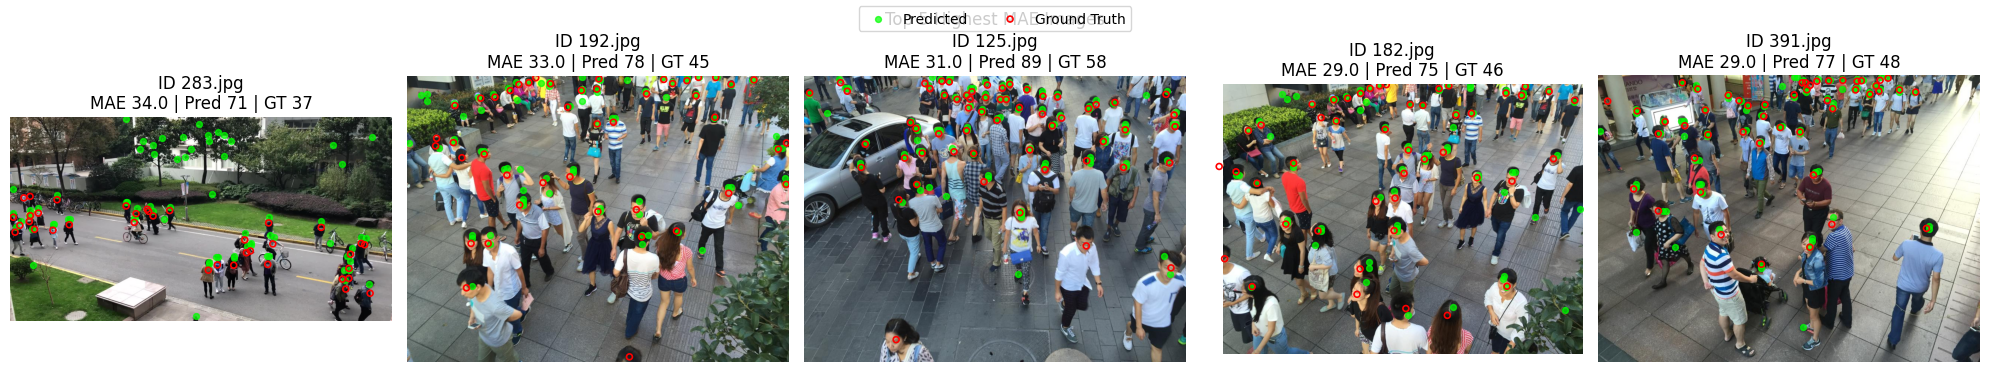

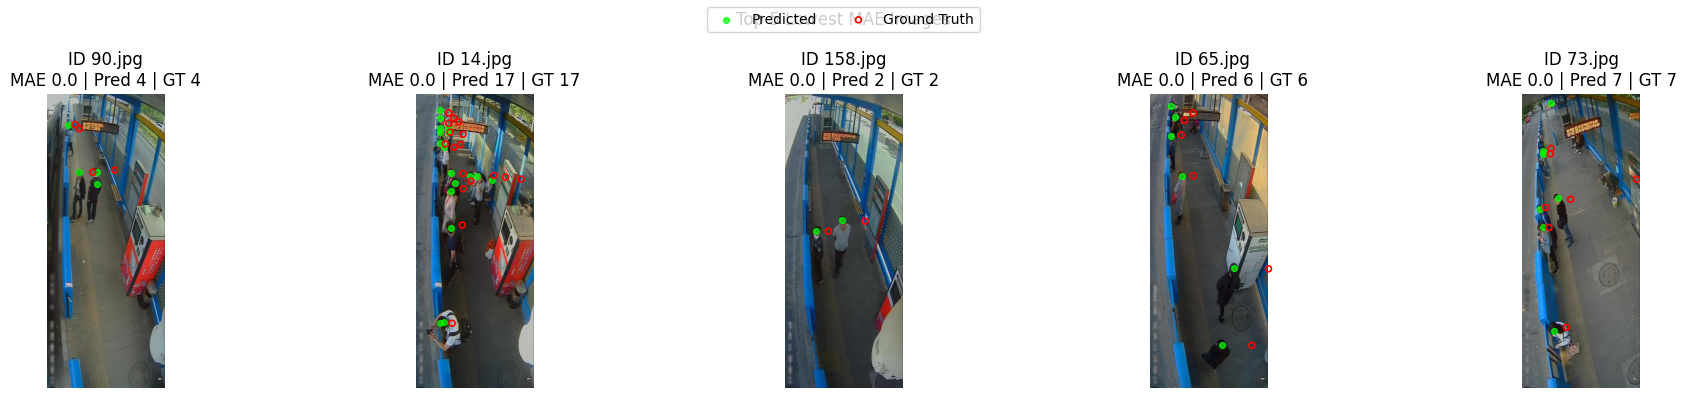

In [59]:
# Model Evaluation — MAE Extremes Visualization
if 'inference_df' not in globals() or inference_df.empty:
    print("Inference dataframe unavailable — run the inference cell first.")
else:
    top_k = inference_df.sort_values('mae', ascending=False).head(5)
    bottom_k = inference_df.sort_values('mae', ascending=True).head(5)

    def plot_rows(df_rows, title):
        if df_rows.empty:
            print(f"No records to show for {title}.")
            return
        fig, axes = plt.subplots(1, len(df_rows), figsize=(4 * len(df_rows), 4))
        if len(df_rows) == 1:
            axes = [axes]
        for ax, (_, row) in zip(axes, df_rows.iterrows()):
            base_img = Image.open(row['image_path']).convert('RGB')
            base_img = base_img.resize((int(row['width']), int(row['height'])))
            base_np = np.array(base_img)
            ax.imshow(base_np)

            pred_pts = np.array(row['pred_points'], dtype=np.float32) if len(row['pred_points']) else np.empty((0, 2), dtype=np.float32)
            gt_pts = np.array(row['gt_points'], dtype=np.float32) if len(row['gt_points']) else np.empty((0, 2), dtype=np.float32)

            if pred_pts.size > 0:
                ax.scatter(pred_pts[:, 0], pred_pts[:, 1], s=18, c='lime', label='Predicted', alpha=0.7)
            if gt_pts.size > 0:
                ax.scatter(gt_pts[:, 0], gt_pts[:, 1], s=18, facecolors='none', edgecolors='red', linewidths=1.2, label='Ground Truth')

            ax.set_title(f"ID {row['image_id']}\nMAE {row['mae']:.1f} | Pred {row['pred_count']} | GT {row['gt_count']}")
            ax.axis('off')

        handles, labels = axes[-1].get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper center', ncol=2)
        fig.suptitle(title)
        plt.tight_layout()
        plt.show()

    plot_rows(top_k, 'Top 5 Highest MAE Images')
    plot_rows(bottom_k, 'Top 5 Lowest MAE Images')

> Visualisasi dengan kode warna membantu menelusuri penyebab utama deviasi MAE, apakah karena occlusion atau pencahayaan yang menyesatkan.

### Kasus Ekstrem <a id="kasus-ekstrem"></a>

Kami menyoroti lima citra dengan MAE tertinggi dan terendah. Visual ini membantu menjawab pertanyaan: kapan model paling tergelincir, dan kapan ia berada di puncak performa?

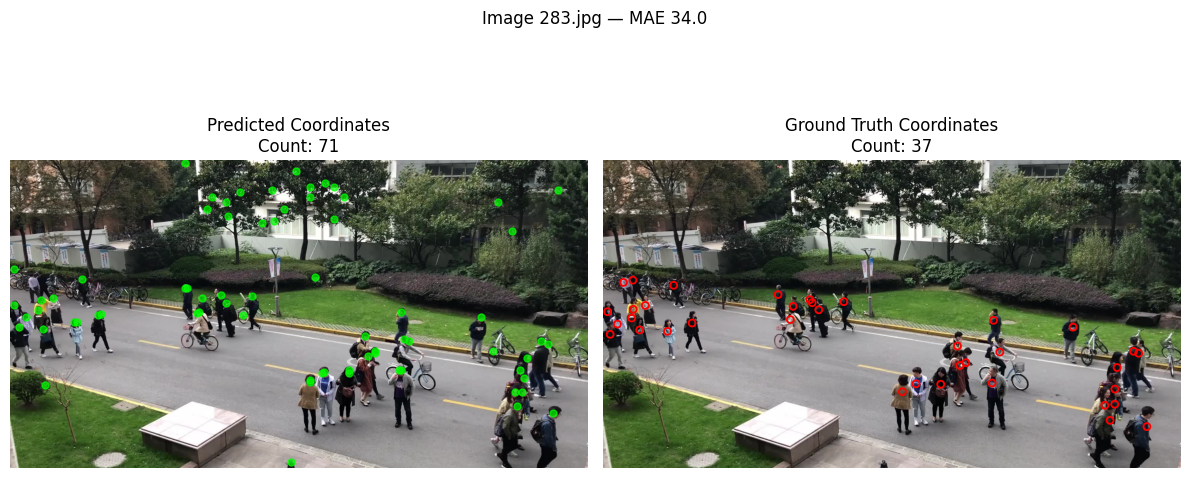

In [60]:
# Model Evaluation — Coordinate Overlay Comparison
if 'inference_df' not in globals() or inference_df.empty:
    print("Inference dataframe unavailable — run the inference cell first.")
else:
    comparison_row = inference_df.sort_values('mae', ascending=False).head(1)
    if comparison_row.empty:
        print("No comparison sample available.")
    else:
        row = comparison_row.iloc[0]
        base_img = Image.open(row['image_path']).convert('RGB')
        base_img = base_img.resize((int(row['width']), int(row['height'])))
        base_np = np.array(base_img)

        pred_pts = np.array(row['pred_points'], dtype=np.float32) if len(row['pred_points']) else np.empty((0, 2), dtype=np.float32)
        gt_pts = np.array(row['gt_points'], dtype=np.float32) if len(row['gt_points']) else np.empty((0, 2), dtype=np.float32)

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        axes[0].imshow(base_np)
        if pred_pts.size > 0:
            axes[0].scatter(pred_pts[:, 0], pred_pts[:, 1], s=25, c='lime', alpha=0.7)
        axes[0].set_title(f"Predicted Coordinates\nCount: {row['pred_count']}")
        axes[0].axis('off')

        axes[1].imshow(base_np)
        if gt_pts.size > 0:
            axes[1].scatter(gt_pts[:, 0], gt_pts[:, 1], s=25, facecolors='none', edgecolors='red', linewidths=1.3)
        axes[1].set_title(f"Ground Truth Coordinates\nCount: {row['gt_count']}")
        axes[1].axis('off')

        fig.suptitle(f"Image {row['image_id']} — MAE {row['mae']:.1f}")
        plt.tight_layout()
        plt.show()

> Perbandingan visual ini mempermudah identifikasi area yang memerlukan penyesuaian pada iterasi model berikutnya.

### Overlay Prediksi vs Ground Truth <a id="overlay-prediksi-vs-ground-truth"></a>

Untuk kasus MAE terbesar, kami menempatkan prediksi dan anotasi berdampingan. Adegan ini memberikan bukti visual apakah kesalahan berasal dari offset, objek palsu, atau kepala yang luput terdeteksi.

---

## Insight & Rekomendasi <a id="insight--rekomendasi"></a>

### Insight Utama
- Distribusi jumlah kepala per patch sangat miring; mayoritas area relatif lengang namun beberapa adegan menampilkan kepadatan ekstrem yang memicu undercount.
- Overlay koordinat membantu mengidentifikasi pola kesalahan: model cenderung kehilangan kepala ketika occlusion tinggi dan pencahayaan kontras.
- Nilai nAP/nAR menurun pada kasus MAE besar, menandakan tantangan bukan sekadar menghitung jumlah tetapi juga memposisikan titik secara presisi.

### Kesimpulan
P2PNet menghadirkan pendekatan point-based yang memadukan counting dan localization secara efektif. Pipeline yang disusun—mulai dari konversi data, eksplorasi statistik, hingga evaluasi visual—memberikan gambaran utuh mengenai kekuatan sekaligus celah model.

### Rekomendasi Lanjutan
1. **Augmentasi Kerumunan Padat:** Perbanyak sampling patch dengan kepadatan tinggi atau terapkan cropping adaptif untuk menekan undercount.
2. **Kalibrasi Ambang Prediksi:** Eksperimenkan threshold skor atau teknik kalibrasi untuk memperbaiki nilai nAP.
3. **Post-processing Spatial:** Pertimbangkan non-maximum suppression ringan atau refinemen lokal guna mengurangi deteksi ganda.
4. **Monitoring Operasional:** Otomatiskan laporan MAE ekstrem supaya tim lapangan segera mengetahui area rawan saat deployment.

### Catatan Model Alternatif <a id="catatan-model-alternatif"></a>
Kami juga melakukan eksperimen paralel dengan keluarga model APGCC untuk membandingkan pendekatan point-based lain yang lebih fokus pada grid classification:
- [APGCC Baseline (Small Res – High Epoch)](https://www.kaggle.com/code/glikolisis/final-hology-notebook-apgcc)
- [APGCC V2 (Small Res – High Epoch, + Low Threshold)](https://www.kaggle.com/code/glukosa/final-hology-notebook-apgcc)
- [APGCC V3 (High Res – Low Epoch)](https://www.kaggle.com/code/arawsardni/final-hology-notebook-apgcc)

> Dokumentasi naratif ini dirancang agar tim berikutnya dapat mengikuti alur masalah, memahami alasan pemilihan pendekatan point-based, dan melanjutkan eksperimen tanpa kehilangan konteks.